In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, auc, roc_curve, average_precision_score, roc_auc_score, precision_recall_curve, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE

sns.set()

## {Put here the name of the modeling you are trying and give a description}

### Helper functions

In [2]:
def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Get accuracy
    right = np.diagonal(cm).sum()
    acc = float(right)/cm.sum()
    print("Accuracy is {} %".format(acc*100))
    tpr = float(cm[1,1])/cm[1,:].sum()
    fpr = float(cm[0,1])/cm[0,:].sum()
    precision = float(cm[1,1])/cm[:,1].sum()
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return acc, tpr, fpr, precision

# Data preprocessing

In [3]:
df = pd.read_csv('data/64_genes.csv')

In [5]:
genes = df[df.columns[df.columns.str.startswith('ENSG')]]

In [6]:
genes = genes.apply(lambda c: (c-c.mean())/c.std(), axis=0)

,ENSG00000134184.11,ENSG00000117650.11,ENSG00000012048.18,ENSG00000137804.11,ENSG00000197170.8,ENSG00000123975.4,ENSG00000131747.13,ENSG00000136997.13,ENSG00000175063.15,ENSG00000228410.4,...,ENSG00000082175.13,ENSG00000139618.13,ENSG00000171791.11,ENSG00000201065.1,ENSG00000229666.1,ENSG00000260832.1,ENSG00000182040.7,ENSG00000261703.1,ENSG00000229743.2,ENSG00000276980.1
0,0.039548,-0.517869,-0.134655,-0.279701,0.349272,-0.449428,-0.367593,-0.429290,-0.615796,-0.086770,...,0.095078,0.285858,0.567911,-0.077981,7.167532,-0.113292,-0.161969,-0.374166,0.110628,0.225512
1,-0.380603,0.291505,1.571961,1.058660,0.786576,0.184932,1.052111,-0.066588,0.300456,-0.086770,...,2.991382,4.729628,1.304220,-0.077981,-0.646066,-0.113292,-0.297788,-0.374166,0.110628,-0.122354
2,-0.381393,-1.045579,-0.530379,-1.094518,-0.385856,-1.061560,-0.692204,-0.519630,-0.865165,-0.086770,...,-0.469150,-0.911628,0.636790,-0.077981,-0.016534,-0.113292,-0.433606,-0.374166,-0.265838,-0.124989
3,-0.382381,-0.182114,-0.594432,-0.367165,1.503553,0.262446,-0.311061,-0.572726,0.124341,-0.086770,...,-0.470892,0.183344,-0.381085,-0.077981,0.612997,-0.113292,-0.320424,-0.374166,-0.265838,0.004143
4,0.394482,-0.934760,-0.853276,-1.010767,-0.975774,0.186072,-0.658521,-0.826543,-0.646160,-0.086770,...,0.380563,-0.924999,-0.635242,-0.077981,0.427841,-0.113292,0.268122,-0.374166,0.110628,-0.214591
5,0.929651,-0.012587,-0.438248,-0.376242,-0.238735,-0.374764,-0.348494,0.090757,-0.647678,-0.086770,...,2.579727,-0.043971,0.300405,-0.077981,0.020497,0.504665,-0.139333,-0.374166,0.110628,0.117463
6,-0.107485,0.145066,0.971793,1.022354,0.008696,0.052132,0.324271,-0.608024,-0.098459,-0.086770,...,0.023847,0.526544,1.078362,-0.077981,-0.201690,-0.113292,-0.410970,1.106908,0.110628,-0.159249
7,-0.381393,-0.199265,-0.543541,-0.282589,-0.702071,-0.485905,0.279268,-0.895643,0.025656,-0.086770,...,-0.482352,-0.565456,-0.877831,-0.077981,-0.534972,-0.113292,-0.094060,-0.374166,-0.265838,-0.117083
8,0.018995,-0.162325,-0.355769,-0.317245,-0.805008,-0.408961,-0.458643,-0.278676,-0.270778,-0.086770,...,-0.081145,-0.590713,-0.616554,-0.077981,-0.312784,-0.113292,-0.433606,-0.374166,-0.265838,-0.140802
9,-0.206890,0.009840,-0.176772,-0.722796,0.944683,-0.233985,-0.213969,0.962888,-0.101875,-0.086770,...,-0.433142,-0.465913,-0.212537,-0.077981,0.575966,0.504665,0.087031,-0.374166,-0.265838,-0.201415


In [7]:
X = genes
y = df['tumor_stage']

# Modeling

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smt = SMOTE()
X_train, y_train = smt.fit_sample(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.


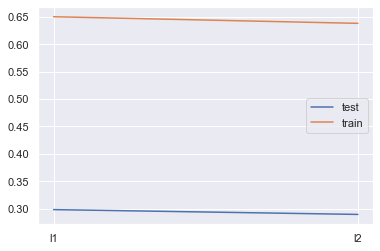

In [36]:
param_values = ['l1', 'l2']
acc_test = []
acc_train = []
for p in param_values:
    clf = LogisticRegression(penalty=p).fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    acc_test.append(acc)
    y_pred = clf.predict(X_train)
    acc = accuracy_score(y_train, y_pred)
    acc_train.append(acc)
plt.plot(param_values, acc_test, label='test')
plt.plot(param_values, acc_train, label='train')
plt.legend()
plt.show()

In [25]:
clf = RandomForestClassifier(n_estimators=100, max_depth=6).fit(X_train, y_train)

In [26]:
y_pred = clf.predict(X_test)

## Results

Accuracy is 40.78947368421053 %


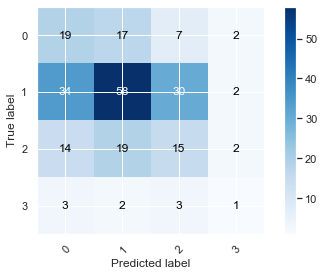

TPR = 0.46774193548387094, FPR = 0.37777777777777777, Precision = 0.6041666666666666


In [27]:
acc, tpr, fpr, precision = plot_confusion_matrix(y_test, y_pred)
plt.show()
print(f"TPR = {tpr}, FPR = {fpr}, Precision = {precision}")